# Per-Symbol Performance Tracking Example

This notebook demonstrates the per-symbol performance tracking feature in BackT.

When trading multiple symbols, BackT now tracks:
- Individual equity curves for each symbol
- Separate performance metrics per symbol
- Correlation matrix of returns between symbols

This allows you to:
1. Identify which symbols contribute most to overall performance
2. Understand diversification through correlation analysis
3. Optimize symbol selection based on individual metrics

In [2]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime

# Import BackT components
from backt import Backtester, BacktestConfig
from backt.reporting import PerformanceReport

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

## Define a Multi-Symbol Strategy

We'll use a simple momentum strategy that trades multiple tech stocks.

In [4]:
def multi_symbol_momentum_strategy(
    market_data,
    current_time,
    positions,
    context,
    params
):
    """
    Simple momentum strategy for multiple symbols
    
    Buys when price > MA, sells when price < MA
    Allocates equal weight across signals
    """
    orders = {}
    
    # Parameters
    ma_period = params.get('ma_period', 20)
    target_weight_per_signal = params.get('weight_per_symbol', 0.25)
    
    # Count active signals
    active_signals = 0
    
    for symbol, data in market_data.items():
        if len(data) < ma_period:
            continue
        
        # Calculate moving average
        ma = data['close'].tail(ma_period).mean()
        current_price = data['close'].iloc[-1]
        
        # Generate signal
        if current_price > ma:
            active_signals += 1
    
    # Calculate weight per position
    if active_signals > 0:
        weight_per_position = min(target_weight_per_signal, 1.0 / active_signals)
    else:
        weight_per_position = 0
    
    # Generate orders
    for symbol, data in market_data.items():
        if len(data) < ma_period:
            continue
        
        # Calculate moving average
        ma = data['close'].tail(ma_period).mean()
        current_price = data['close'].iloc[-1]
        
        # Generate signal
        if current_price > ma:
            # Buy/hold signal
            orders[symbol] = {
                'action': 'target_weight',
                'weight': weight_per_position
            }
        else:
            # Close position
            if symbol in positions and positions[symbol].qty != 0:
                orders[symbol] = {'action': 'close'}
    
    return orders

## Configure and Run Backtest

In [6]:
# Configuration
config = BacktestConfig(
    start_date='2023-01-01',
    end_date='2024-01-01',
    initial_capital=100000,
    use_mock_data=False  # Use real Yahoo Finance data
)

# Create backtester
backtester = Backtester(config)

# Define universe of symbols
universe = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA']

# Strategy parameters
strategy_params = {
    'ma_period': 20,
    'weight_per_symbol': 0.20  # Target 20% per symbol
}

print(f"Running backtest on {len(universe)} symbols: {', '.join(universe)}")
print(f"Period: {config.start_date} to {config.end_date}")
print(f"Initial Capital: ${config.initial_capital:,.0f}")
print("\nExecuting...")

2025-10-04 17:54:51,848 - backt.Backtester - INFO - Using Yahoo Finance data loader
Running backtest on 5 symbols: AAPL, MSFT, GOOGL, NVDA, TSLA
Period: 2023-01-01 to 2024-01-01
Initial Capital: $100,000

Executing...


In [7]:
# Run backtest
result = backtester.run(
    strategy=multi_symbol_momentum_strategy,
    universe=universe,
    strategy_params=strategy_params
)

print("\nBacktest completed!")
print(f"Total runtime: {result.total_runtime_seconds:.2f} seconds")
print(f"Total trades: {len(result.trades)}")

2025-10-04 17:54:51,859 - backt.Backtester - INFO - Starting backtest
2025-10-04 17:54:51,860 - backt.Backtester - INFO - Loading data for 5 symbols
2025-10-04 17:54:51,860 - backt.YahooDataLoader - INFO - Loading Yahoo Finance data for ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA']


[*********************100%***********************]  5 of 5 completed

2025-10-04 17:54:52,853 - backt.Backtester - INFO - Backtesting 250 periods from 2023-01-03 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
2025-10-04 17:54:52,857 - backt.Backtester - INFO - Progress: 0.4% - 2023-01-03 - Equity: $100,000.00


2025-10-04 17:54:53,344 - backt.Backtester - INFO - Progress: 40.4% - 2023-05-26 - Equity: $24,201.34
2025-10-04 17:54:53,847 - backt.Backtester - INFO - Progress: 80.4% - 2023-10-19 - Equity: $-36,877.54
2025-10-04 17:54:54,078 - backt.Backtester - INFO - Progress: 100.0% - 2023-12-29 - Equity: $-62,400.94
2025-10-04 17:54:54,269 - backt.Backtester - INFO - Backtest completed in 2.41 seconds

Backtest completed!
Total runtime: 2.41 seconds
Total trades: 831


## Overall Portfolio Performance

First, let's look at the overall portfolio metrics.

In [9]:
# Create performance report
report = PerformanceReport(result)

# Display overall metrics
report.print_report()

2025-10-04 17:54:54,326 - backt.PerformanceReport - INFO - Fetching benchmark data for SPY...
2025-10-04 17:54:54,715 - backt.PerformanceReport - INFO - Benchmark loaded: 27.08% total return
📊 PERFORMANCE ANALYSIS

📈 RETURN METRICS:
-------------------------
Total Return:             -162.40%
Annualized Return:         -19.91%
CAGR:                        0.00%

⚠️  RISK METRICS:
--------------------
Volatility:                187.57%
Sharpe Ratio:               -0.106
Sortino Ratio:              -0.093
Maximum Drawdown:         -162.40%
Calmar Ratio:                0.000

📊 TRADING ACTIVITY:
------------------------
Total Trades:                  831
Win Rate:                    42.9%
Profit Factor:                0.08
Average Trade:               0.00%

💼 PORTFOLIO SUMMARY:
-------------------------
Initial Capital:          $   100,000
Final Value:              $   -62,401
Profit/Loss:              $  -162,401

🎯 PERFORMANCE ASSESSMENT:
------------------------------
Sharpe Rating: 

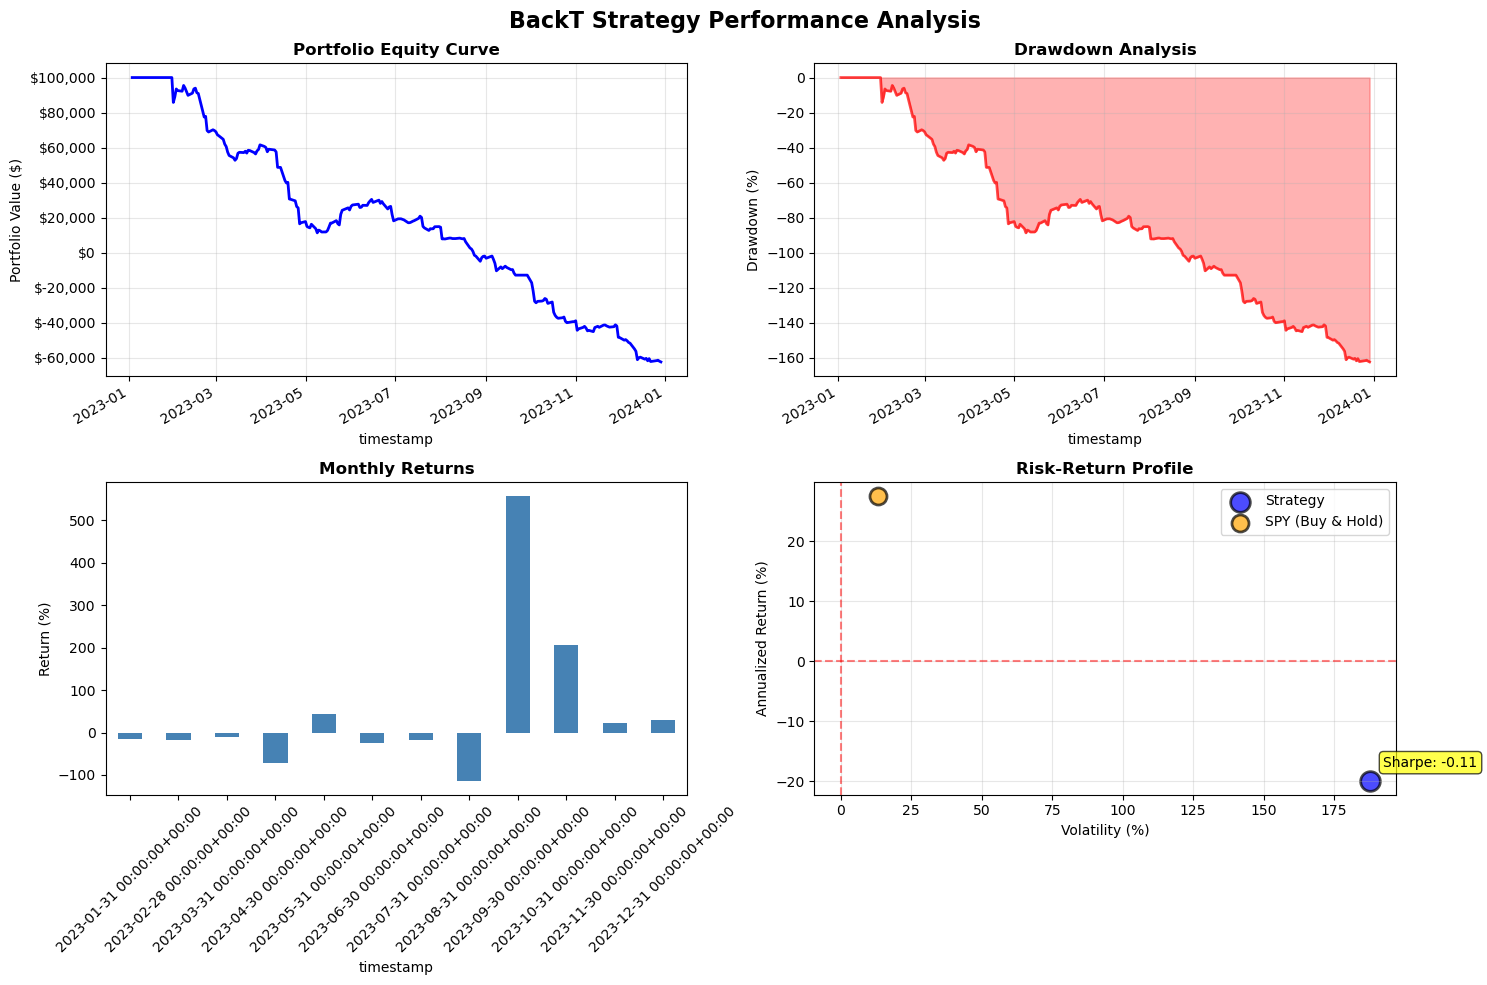

In [10]:
# Show overall charts
report.show_charts()

## Per-Symbol Performance Analysis

Now let's examine individual symbol performance.

In [12]:
# Get per-symbol metrics as DataFrame
per_symbol_df = report.get_per_symbol_metrics_dataframe(transpose=True)

print("\nPER-SYMBOL METRICS:")
print("=" * 100)
display(per_symbol_df)


PER-SYMBOL METRICS:


,total_pnl,final_pnl,avg_pnl_per_period,pnl_volatility,annualized_volatility,sharpe_ratio,sortino_ratio,best_day,worst_day,positive_days,max_drawdown,trades_total_trades,trades_avg_commission,trades_total_commission,trades_win_rate,trades_profit_factor,trades_avg_trade_pnl,trades_avg_trade_pnl_pct,trades_num_winning_trades,trades_num_losing_trades,trades_gross_profit,trades_gross_loss
AAPL,-10715.36,-11976.37,-46.59,368.95,2660.52,-0.91,-0.76,930.34,-1831.43,0.38,-13120.53,173.00,0.01,2.10,0.48,0.07,-124.75,-0.06,46.00,50.00,929.69,12906.06
MSFT,-5672.28,-6299.20,-24.66,333.70,2406.31,-0.53,-0.63,923.13,-1248.89,0.38,-8389.00,175.00,0.01,1.54,0.63,0.33,-59.93,-0.02,62.00,36.00,2905.16,8778.49
GOOGL,-48830.69,-50648.51,-212.31,710.05,5120.26,-2.16,-1.87,1432.22,-3071.03,0.31,-51151.34,162.00,0.04,5.98,0.19,0.00,-567.34,-0.13,17.00,71.00,188.94,50115.11
NVDA,-82560.16,-92476.30,-358.96,1672.95,12063.85,-1.55,-1.11,4569.66,-9527.53,0.40,-86266.56,177.00,0.07,12.98,0.11,0.01,-882.74,-0.35,11.00,90.00,520.84,89677.15
TSLA,-392.48,-976.14,-1.71,537.58,3876.58,-0.02,-0.02,1968.02,-2195.50,0.33,-10187.90,144.00,0.01,1.82,0.76,0.88,-14.64,-0.01,65.00,20.00,8744.94,9988.99


In [13]:
# Print formatted per-symbol metrics
report.print_per_symbol_metrics()


PER-SYMBOL PERFORMANCE METRICS
       total_pnl  final_pnl  avg_pnl_per_period  pnl_volatility  annualized_volatility  sharpe_ratio  sortino_ratio  best_day  worst_day  positive_days  max_drawdown  trades_total_trades  trades_avg_commission  trades_total_commission  trades_win_rate  trades_profit_factor  trades_avg_trade_pnl  trades_avg_trade_pnl_pct  trades_num_winning_trades  trades_num_losing_trades  trades_gross_profit  trades_gross_loss
AAPL   -10715.36  -11976.37              -46.59          368.95                2660.52         -0.91          -0.76    930.34   -1831.43           0.38     -13120.53               173.00                   0.01                     2.10             0.48                  0.07               -124.75                     -0.06                      46.00                     50.00               929.69           12906.06
MSFT    -5672.28   -6299.20              -24.66          333.70                2406.31         -0.53          -0.63    923.13   -1248.89  

### Key Per-Symbol Metrics Explained:

- **total_pnl**: Total profit/loss from this symbol
- **sharpe_ratio**: Risk-adjusted return for this symbol
- **sortino_ratio**: Downside risk-adjusted return
- **max_drawdown**: Maximum loss from peak for this symbol
- **positive_days**: Percentage of days with positive PnL
- **annualized_volatility**: Annual volatility of PnL changes

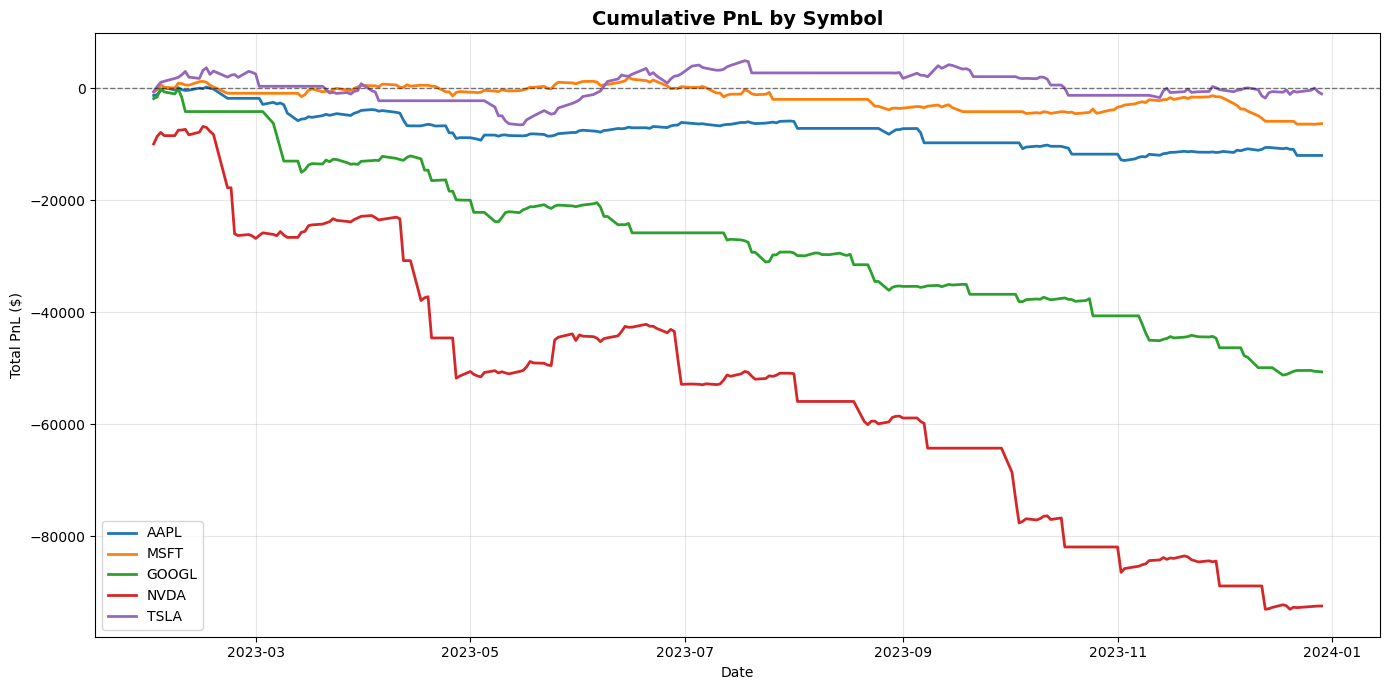

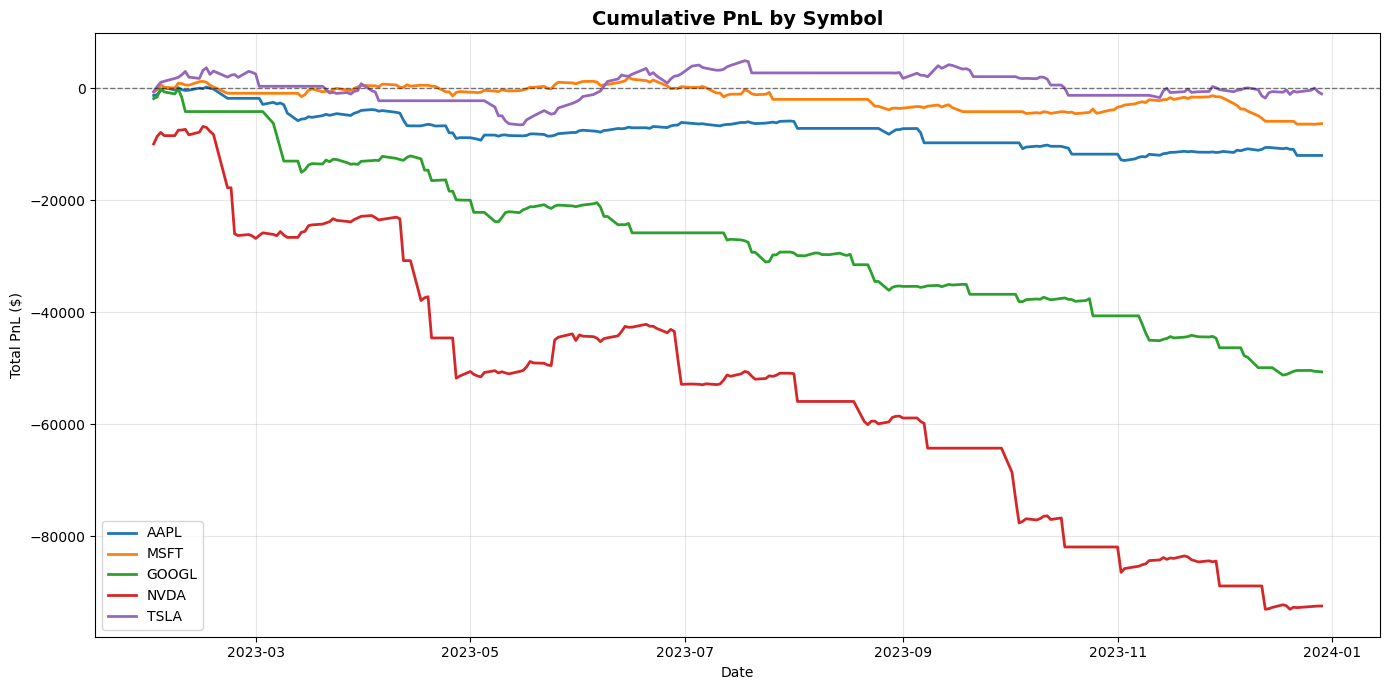

In [15]:
# Plot cumulative PnL by symbol
report.plot_per_symbol_pnl(figsize=(14, 7))

## Correlation Analysis

Understanding correlations between symbols helps assess diversification.

In [17]:
# Get correlation matrix
corr_matrix = report.get_correlation_matrix()

print("\nRETURNS CORRELATION MATRIX:")
print("=" * 80)
display(corr_matrix)


RETURNS CORRELATION MATRIX:


,AAPL,MSFT,GOOGL,NVDA,TSLA
AAPL,1.00,0.23,0.12,0.32,0.16
MSFT,0.23,1.00,0.15,0.12,0.25
GOOGL,0.12,0.15,1.00,0.10,0.06
NVDA,0.32,0.12,0.10,1.00,0.15
TSLA,0.16,0.25,0.06,0.15,1.00


In [18]:
# Print correlation matrix
report.print_correlation_matrix()


RETURNS CORRELATION MATRIX
       AAPL  MSFT  GOOGL  NVDA  TSLA
AAPL   1.00  0.23   0.12  0.32  0.16
MSFT   0.23  1.00   0.15  0.12  0.25
GOOGL  0.12  0.15   1.00  0.10  0.06
NVDA   0.32  0.12   0.10  1.00  0.15
TSLA   0.16  0.25   0.06  0.15  1.00



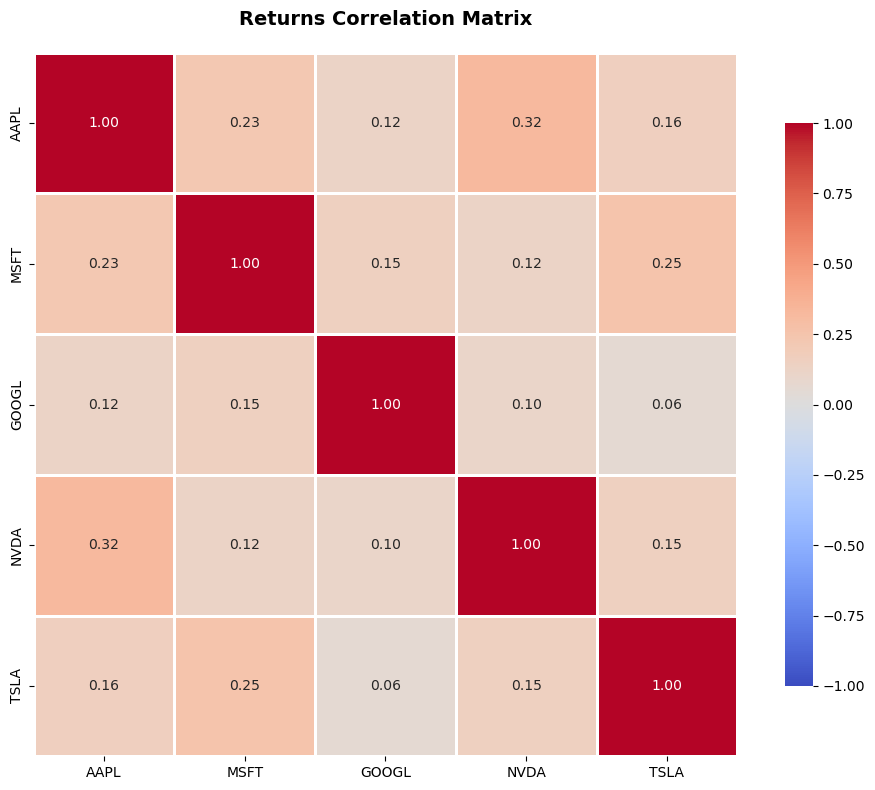

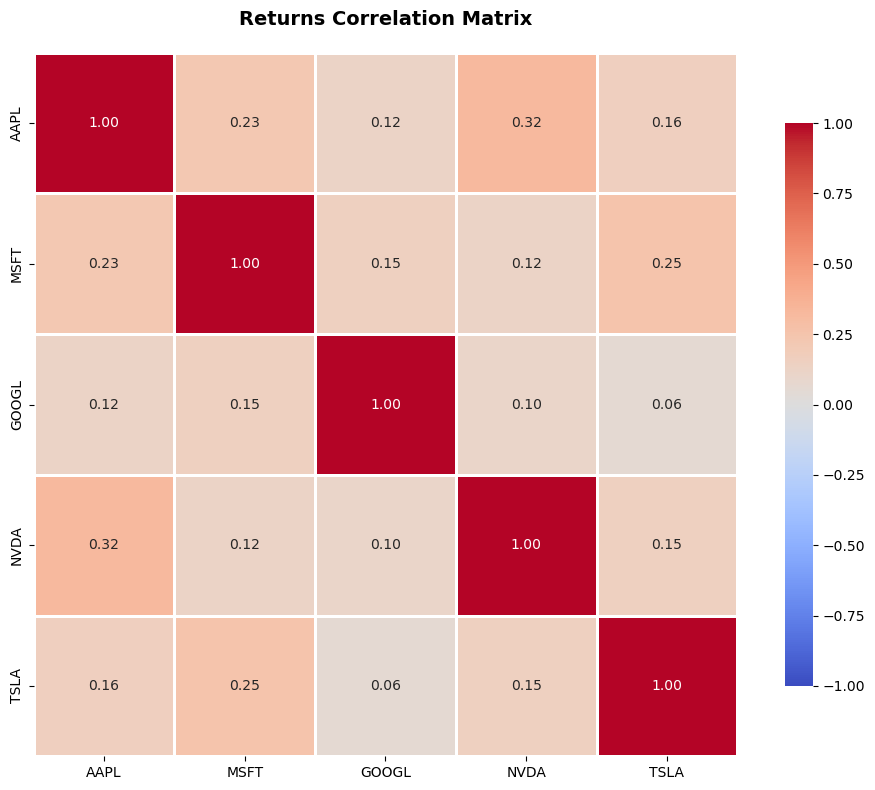

In [19]:
# Visualize correlation matrix as heatmap
report.plot_correlation_heatmap(figsize=(10, 8))

### Correlation Insights:

- **High positive correlation (>0.7)**: Symbols move together, less diversification
- **Low correlation (<0.3)**: Symbols move independently, good diversification
- **Negative correlation (<0)**: Symbols move in opposite directions, strong diversification

## Comprehensive Per-Symbol Report

Generate all per-symbol analysis in one call.


PER-SYMBOL PERFORMANCE METRICS
       total_pnl  final_pnl  avg_pnl_per_period  pnl_volatility  annualized_volatility  sharpe_ratio  sortino_ratio  best_day  worst_day  positive_days  max_drawdown  trades_total_trades  trades_avg_commission  trades_total_commission  trades_win_rate  trades_profit_factor  trades_avg_trade_pnl  trades_avg_trade_pnl_pct  trades_num_winning_trades  trades_num_losing_trades  trades_gross_profit  trades_gross_loss
AAPL   -10715.36  -11976.37              -46.59          368.95                2660.52         -0.91          -0.76    930.34   -1831.43           0.38     -13120.53               173.00                   0.01                     2.10             0.48                  0.07               -124.75                     -0.06                      46.00                     50.00               929.69           12906.06
MSFT    -5672.28   -6299.20              -24.66          333.70                2406.31         -0.53          -0.63    923.13   -1248.89  

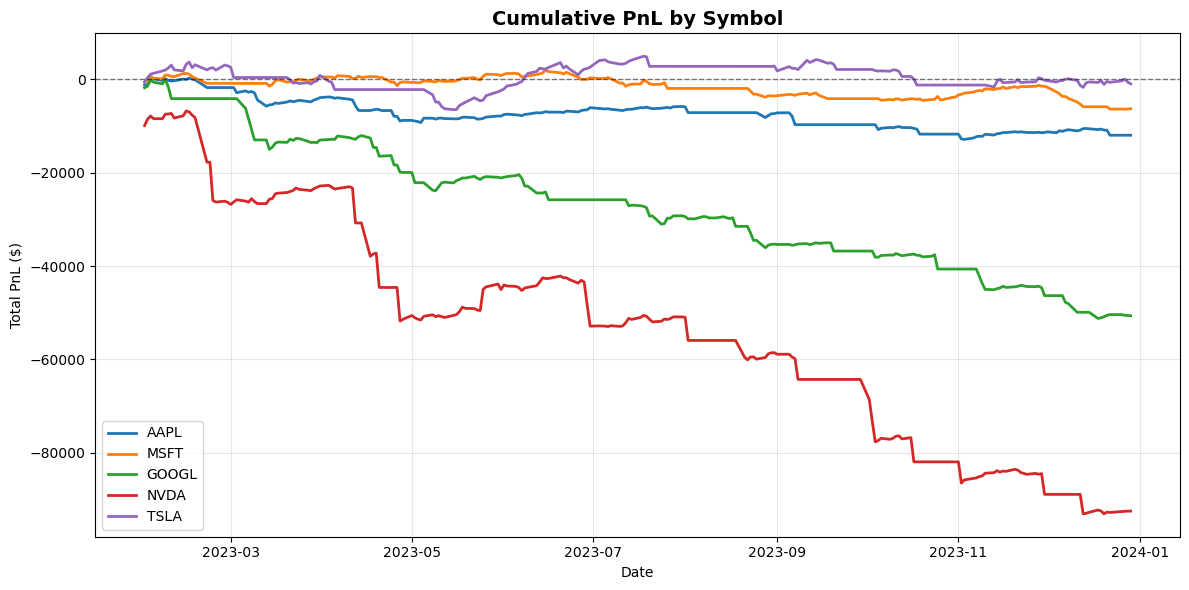

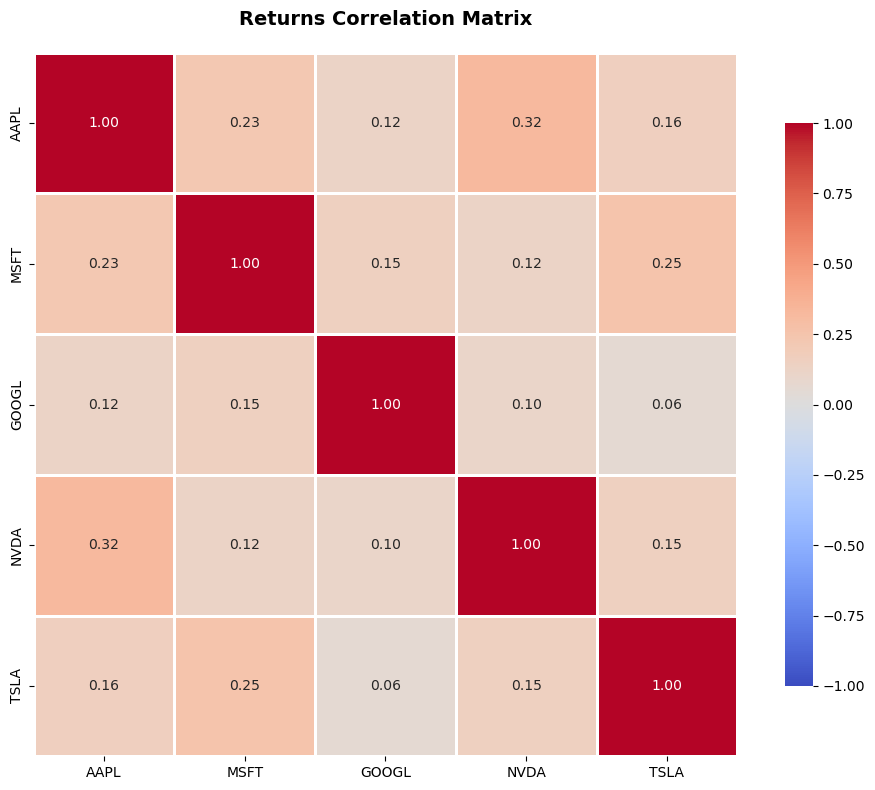

In [22]:
# Generate full per-symbol report
report.generate_per_symbol_report(show_plots=True)

## Analyze Top/Bottom Performers

In [24]:
# Identify best and worst performers
per_symbol_metrics = result.per_symbol_metrics

# Create summary DataFrame
summary_data = []
for symbol, metrics in per_symbol_metrics.items():
    summary_data.append({
        'Symbol': symbol,
        'Total PnL': metrics.get('total_pnl', 0),
        'Sharpe': metrics.get('sharpe_ratio', 0),
        'Sortino': metrics.get('sortino_ratio', 0),
        'Max DD': metrics.get('max_drawdown', 0),
        'Win Rate': metrics.get('positive_days', 0)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Total PnL', ascending=False)

print("\nSYMBOL PERFORMANCE RANKING:")
print("=" * 80)
display(summary_df)

print(f"\nBest Performer: {summary_df.iloc[0]['Symbol']} (PnL: ${summary_df.iloc[0]['Total PnL']:,.2f})")
print(f"Worst Performer: {summary_df.iloc[-1]['Symbol']} (PnL: ${summary_df.iloc[-1]['Total PnL']:,.2f})")


SYMBOL PERFORMANCE RANKING:


,Symbol,Total PnL,Sharpe,Sortino,Max DD,Win Rate
4,TSLA,-392.48,-0.02,-0.02,-10187.90,0.33
1,MSFT,-5672.28,-0.53,-0.63,-8389.00,0.38
0,AAPL,-10715.36,-0.91,-0.76,-13120.53,0.38
2,GOOGL,-48830.69,-2.16,-1.87,-51151.34,0.31
3,NVDA,-82560.16,-1.55,-1.11,-86266.56,0.40



Best Performer: TSLA (PnL: $-392.48)
Worst Performer: NVDA (PnL: $-82,560.16)


## Access Raw Per-Symbol Data

For custom analysis, you can access the raw equity curves.

In [26]:
# Access per-symbol equity curves
per_symbol_curves = result.per_symbol_equity_curves

print("\nAvailable symbols:", list(per_symbol_curves.keys()))

# Example: Show equity curve for a specific symbol
example_symbol = list(per_symbol_curves.keys())[0]
print(f"\nEquity curve for {example_symbol}:")
display(per_symbol_curves[example_symbol].head())

print("\nColumns available:")
print(per_symbol_curves[example_symbol].columns.tolist())


Available symbols: ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA']

Equity curve for AAPL:


,position_value,qty,price,avg_price,unrealized_pnl,realized_pnl,total_pnl
timestamp,,,,,,,
2023-01-31 00:00:00+00:00,20000.00,140.56,142.28,151.25,-1261.01,0.00,-1261.01
2023-02-01 00:00:00+00:00,20000.00,139.46,143.41,151.25,-1094.35,-10.33,-1104.68
2023-02-02 00:00:00+00:00,20000.00,134.48,148.72,151.25,-340.48,-30.43,-370.91
2023-02-03 00:00:00+00:00,20000.00,131.28,152.35,151.25,144.01,-33.69,110.31
2023-02-06 00:00:00+00:00,20000.00,133.67,149.62,151.23,-215.51,-33.69,-249.20



Columns available:
['position_value', 'qty', 'price', 'avg_price', 'unrealized_pnl', 'realized_pnl', 'total_pnl']


## Summary

This notebook demonstrated:

1. **Per-symbol metrics**: Track individual performance for each symbol
2. **Correlation analysis**: Understand relationships between symbols
3. **Visual analysis**: Charts showing PnL by symbol and correlation heatmaps
4. **Performance ranking**: Identify top and bottom performers

### Use Cases:

- **Portfolio optimization**: Identify which symbols add value
- **Diversification**: Assess correlation to ensure true diversification
- **Strategy refinement**: Remove underperforming symbols or adjust weights
- **Risk management**: Identify symbols with excessive drawdowns